# Imports y configuraciones básicas

Algunos imports que se utilizarán en el resto del notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from bwb.distributions import *
from bwb.utils import *

import pandas as pd
import itertools

In [3]:
import logging
log = logging.getLogger("bwb.distributions")
log.setLevel(logging.WARNING)
# log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

Importamos los datos del archivo de Google Cloud

In [4]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Haremos dos listas de caritas: una sin modificación, y otra con modificación.

In [5]:
%%time

CEIL = 50
n_faces = len(data)
rng = np.random.default_rng(42)


# Builder para hacer las caritas
dist_draw_builder = DistributionDrawBuilder(
    seed=rng,
)

# Conjunto de caritas originales (distintos soportes)
faces_original = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_original.append(dd_arr)
    
    
# Conjuntos de caritas con soporte no-nulo
dist_draw_builder.set_ceil(CEIL)
    
faces_modified = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_modified.append(dd_arr)
    
len(faces_original), len(faces_modified)

CPU times: total: 17 s
Wall time: 17.3 s


(161666, 161666)

`faces_original` son las caritas sin modificar el soporte, mientras que `faces_modified` es con los que tiene soporte no-nulo.

In [6]:
plot_list_of_draws(faces_original)

In [7]:
plot_list_of_draws(faces_modified)

Obtendremos la data $D = \{x_i\}_{i=1}^{n}\subseteq\mathcal{X}^n$, y probaremos los métodos para distintos valores de $n$.

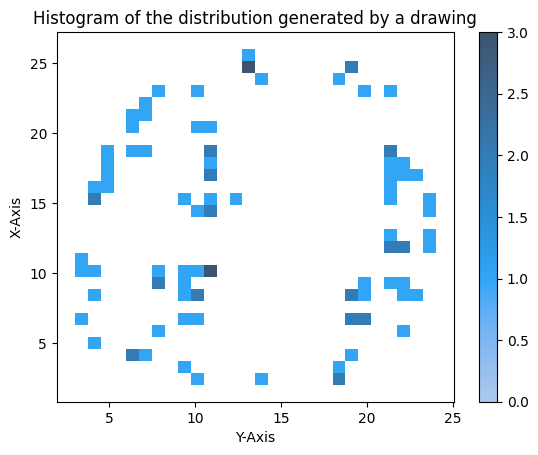

In [8]:
first_face = DistributionDraw.fromarray(
    255 - data[0, :].reshape(28, 28),
    seed=42
)

x = first_face.rvs(size=100)

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

Probamos la log-probabilidad

In [9]:
log_matrix, log_matrix2 = first_face.log_matrix, faces_original[1].log_matrix


Se armará la matriz de conteo de las coordenadas de datos.

In [10]:
from collections import Counter
import numpy.ma as ma

counter_data = Counter(x[:10])
matrix_data = np.zeros((28, 28)).astype(int)
for coord, val in counter_data.items():
    matrix_data[coord] = val

matrix_data = ma.masked_less(matrix_data, 1)
# matrix_data.data[~matrix_data.mask] * log_matrix[~matrix_data.mask]

Ahora se calculará la log-verosimilitud, dado que se conoce que
\begin{equation}
    \mathcal{L}_n(\mu) = \prod_{i=1}^{n} f_\mu(x_i)
\end{equation}

Entonces la log-verosimilud sería
\begin{equation}
    \ell_n(\mu) = \sum_{i=1}^{n} \ln(f_\mu(x_i))
\end{equation}

Si consideramos $\{x_{i_j}\}_{j=1}^m$ las coordenadas en que aparecen una sola vez, y por $n_j$ el número de veces que aparece la coordenada $x_{i_j}$, entonces la (log) verosimilitud se reescribe por
\begin{align*}
    \mathcal{L}_n(\mu) &= \prod_{j=1}^{m} f_\mu(x_{i_j})^{n_j} &
    \ell_n(\mu) &= \sum_{j=1}^{m} n_j \ln(f_\mu(x_{i_j}))
\end{align*}

In [11]:
log_likelihood = np.sum(log_matrix * matrix_data)
log_likelihood2 = np.sum(log_matrix2 * matrix_data)
log_likelihood, log_likelihood2

(-55.033404436099275, -inf)

In [12]:
mcmc = GibbsPosteriorPiN(data=x[:10], models=faces_original[:10], seed=rng)

mcmc.likelihood(first_face), np.exp(log_likelihood)

(1.2568867068560284e-24, 1.2568867068560372e-24)

# Experimento correr MCMC largo tiempo

In [13]:
from pathlib import Path
import pickle

PICKLES_PATH = Path("./pickles")

def save_mcmc(mcmc: MCMCPosteriorPiN, path):
    models, mcmc.models = mcmc.models, None
    with open(path, "wb") as f:
        pickle.dump(mcmc, f)
    mcmc.models = models

    return models

def load_mcmc(path, models):
    with open(path, "rb") as f:
        mcmc = pickle.load(f)
    mcmc.models = models

    return mcmc

In [14]:
# %%script false --no-raise-error
import time

SAVE = False
MODELS_ORIGINAL = faces_original
PATH_MCMC_ORIGINAL = PICKLES_PATH / f"mcmc-gibbs-original.dat"
MODELS_MODIFIED = faces_modified
PATH_MCMC_MODIFIED = PICKLES_PATH / f"mcmc-gibbs-modified.dat"

if SAVE:
    tic = time.time()
    mcmc_original = GibbsPosteriorPiN(data=x[:10], models=MODELS_ORIGINAL, seed=rng)
    save_mcmc(mcmc_original, PATH_MCMC_ORIGINAL)
    toc = time.time()

    print(f"Tiempo cálculo de caché original: {toc - tic:.4f} [seg]")

    tic = time.time()
    mcmc_modified = GibbsPosteriorPiN(data=x[:10], models=MODELS_MODIFIED, seed=rng)
    save_mcmc(mcmc_modified, PATH_MCMC_MODIFIED)
    toc = time.time()

    print(f"Tiempo cálculo de caché modified: {toc - tic:.4f} [seg]")
else:
    mcmc_original = load_mcmc(PATH_MCMC_ORIGINAL, MODELS_ORIGINAL)
    mcmc_modified = load_mcmc(PATH_MCMC_MODIFIED, MODELS_MODIFIED)
    
mcmc_original, mcmc_modified

(GibbsPosteriorPiN(n_data=10, n_models=161666, n_samples=8111, last_i=83743, likelihood_sum=2.8442e-21),
 GibbsPosteriorPiN(n_data=10, n_models=161666, n_samples=0, last_i=125122, likelihood_sum=4.1760e-23))

In [15]:
print(f"Soporte original: {sum(np.isfinite(mcmc_original.log_likelihood_cache))}")
print(f"Soporte modified: {sum(np.isfinite(mcmc_modified.log_likelihood_cache))}")

Soporte original: 3393
Soporte modified: 161666


In [16]:
TIEMPO_TOTAL = 1 * 24 * 60 * 60  # 2.5 días
SALVAR_CADA = 5 * 60 # 1 minutos
n = int(TIEMPO_TOTAL / SALVAR_CADA)

tic, toc = time.time(), time.time()

total_time = 0.
for i in range(n):
    print(f"Empezando la iteración {i = }")
    tic_ = time.time()
    while toc - tic_ <= SALVAR_CADA:
        mcmc_original.draw()
        toc = time.time()
    total_time += toc - tic_
    print("Salvando mcmc original...")
    save_mcmc(mcmc_original, PATH_MCMC_ORIGINAL)
    print("mcmc original salvado!")

    # tic_ = time.time()
    # while toc - tic_ <= SALVAR_CADA:
    #     mcmc_modified.draw()
    #     toc = time.time()
    # total_time += toc - tic_
    # print("Salvando mcmc modified...")
    # save_mcmc(mcmc_modified, PATH_MCMC_MODIFIED)
    # print("mcmc modified salvado!")

    print(f"{i = }; {toc-tic = :.4f} [seg]")

Empezando la iteración i = 0
Salvando mcmc original...
mcmc original salvado!
i = 0; toc-tic = 309.1687 [seg]
Empezando la iteración i = 1


KeyboardInterrupt: 

In [17]:
# %%script false --no-raise-error
mcmc = mcmc_original

hours = int(mcmc.total_time // 3600)
minutes = int((mcmc.total_time % 3600) // 60)
seconds = (mcmc.total_time % 3600) % 60
print(f"Número de muestreos después de {hours} horas, {minutes} minutos y {seconds:.2f} segundos: {mcmc.samples_counter.total()}")
print(f"Número de muestreos por segundo: {mcmc.samples_counter.total() / mcmc.total_time:.4f}")
print(f"Número de muestreos diferentes: {len(mcmc.samples_counter)}")
print(f"Número de iteraciones después de {hours} horas, {minutes} minutos y {seconds:.2f} segundos: {mcmc.steps_counter.total()}")
print(f"Número de iteraciones por segundo: {mcmc.steps_counter.total() / mcmc.total_time:.4f}")
print(f"Número de iteraciones diferentes: {len(mcmc.steps_counter)}")

Número de muestreos después de 43 horas, 46 minutos y 51.85 segundos: 8140
Número de muestreos por segundo: 0.0516
Número de muestreos diferentes: 721
Número de iteraciones después de 43 horas, 46 minutos y 51.85 segundos: 8119812
Número de iteraciones por segundo: 51.5178
Número de iteraciones diferentes: 2681


In [18]:
# %%script false --no-raise-error
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

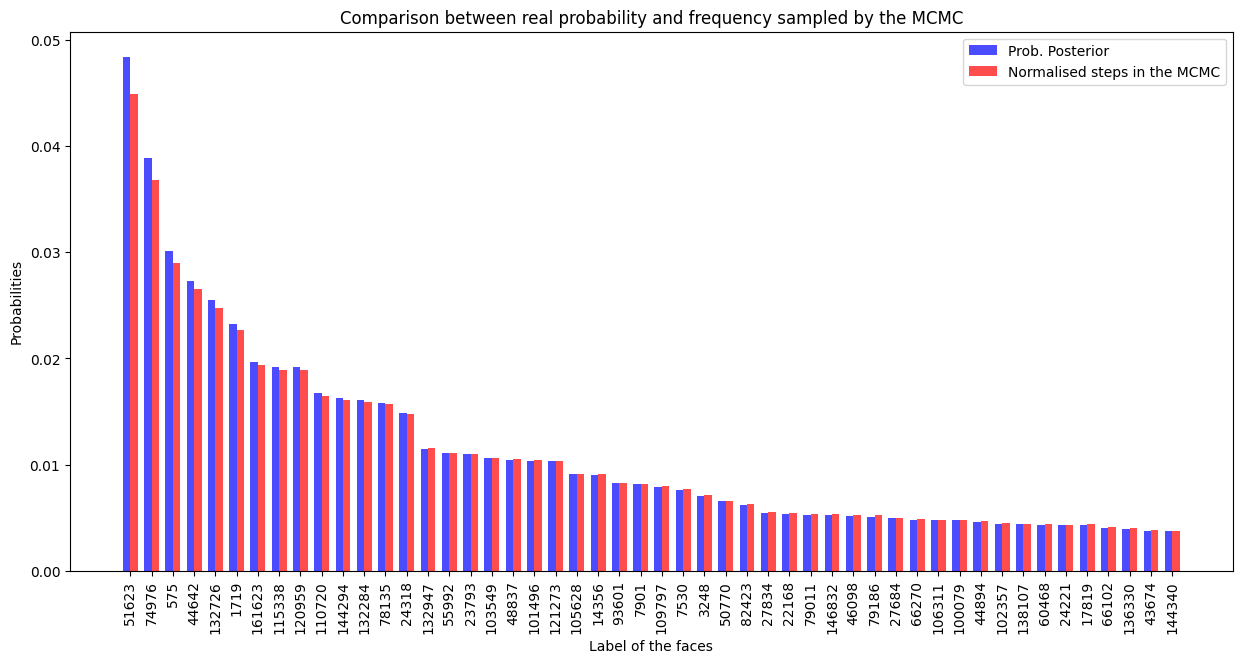

In [19]:
plt.figure(figsize=(15, 7))
posterior_probs_keys = list(likelihood_ordered_dict(mcmc).keys())[:50]
str_keys_list = [str(k) for k in posterior_probs_keys]
posterior_probs_values = [likelihood_ordered_dict(mcmc)[k] for k in posterior_probs_keys]

normalised_steps_values = [normalised_steps_ordered_dict(mcmc).get(k, 0) for k in posterior_probs_keys]

normalised_samples = [normalised_samples_ordered_dict(mcmc).get(k, 0) for k in posterior_probs_keys]

plt.bar(str_keys_list, posterior_probs_values,
        width=-0.35, align="edge", color="b", alpha=0.7, label="Prob. Posterior")

# plt.bar(str_keys_list, normalised_samples,
#         width=0.35, align="edge", color="r", alpha=0.7, label="Normalised samples in the MCMC")

plt.bar(str_keys_list, normalised_steps_values,
        width=0.35, align="edge", color="r", alpha=0.7, label="Normalised steps in the MCMC")

plt.title("Comparison between real probability and frequency sampled by the MCMC")
plt.xlabel("Label of the faces")
plt.ylabel("Probabilities")
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Probando clase `MetropolisPosteriorPiN` datos originales

En esta sección se intentará simular la implementación del algoritmo de *Metropolis* programado en el notebook 05.

In [15]:
%%time
mcmc = MetropolisPosteriorPiN(data=x[:10], models=faces_original, seed=rng)

2023-03-20 10:33:23,878: INFO [bwb.distributions:270] init PosteriorPiN: n_data=10, n_models=161666
2023-03-20 10:34:06,004: INFO [bwb.distributions:409] Executing _first_step
2023-03-20 10:34:06,019: INFO [bwb.distributions:412] First model selected: 124789.


CPU times: total: 41.9 s
Wall time: 42.1 s


Muestreamos a partir de de esta instancia.

In [16]:
%%time
mcmc.rvs(size=100)
mcmc

2023-03-20 10:34:06,096: INFO [bwb.distributions:447] i = 1: last_i = 124789 -> next_i = 137652.
2023-03-20 10:34:06,704: INFO [bwb.distributions:447] i = 13: last_i = 137652 -> next_i = 74234.
2023-03-20 10:34:06,743: INFO [bwb.distributions:447] i = 14: last_i = 74234 -> next_i = 23793.
2023-03-20 10:34:08,106: INFO [bwb.distributions:343] ========== n samples: 1, total time: 2.0576 [seg] ==========
2023-03-20 10:34:08,262: INFO [bwb.distributions:447] i = 75: last_i = 23793 -> next_i = 132726.
2023-03-20 10:34:09,693: INFO [bwb.distributions:343] ========== n samples: 2, total time: 1.5833 [seg] ==========
2023-03-20 10:34:11,287: INFO [bwb.distributions:343] ========== n samples: 3, total time: 1.5924 [seg] ==========
2023-03-20 10:34:13,162: INFO [bwb.distributions:343] ========== n samples: 4, total time: 1.8672 [seg] ==========
2023-03-20 10:34:13,376: INFO [bwb.distributions:447] i = 276: last_i = 132726 -> next_i = 27834.
2023-03-20 10:34:14,557: INFO [bwb.distributions:447] i

CPU times: total: 3min 4s
Wall time: 3min 7s


MetropolisPosteriorPiN(n_data=10, n_models=161666, n_samples=100, last_i=24221)

Y mostramos las caras en orden de la más común a la menos común

In [17]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

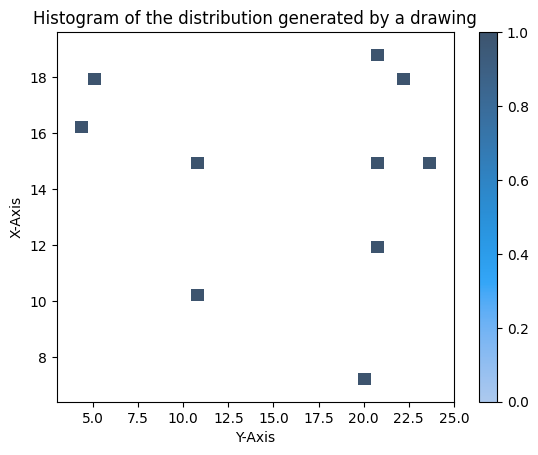

In [18]:
plot_histogram_from_points(x[:10], histplot_kwargs=dict(bins=28))
plt.show()

# Probando clase `AlternativeMetropolisPosteriorPiN` datos originales

En esta sección se intentará simular la implementación del algoritmo de *Metropolis* programado en el notebook 05.

In [19]:
# %%time
# mcmc = AlternativeMetropolisPosteriorPiN(data=x[:10], models=faces_original, seed=rng)

Muestreamos a partir de de esta instancia.

In [20]:
# %%time
# mcmc.rvs(size=1_000)
# mcmc

Y mostramos las caras en orden de la más común a la menos común

In [21]:
# plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# Probando clase `GibbsPosteriorPiN` datos originales

Hacemos lo mismo, pero para la clase `GibbsPosteriorPiN`.

In [22]:
%%time
mcmc = GibbsPosteriorPiN(data=x[:10], models=faces_original, seed=rng)

2023-03-20 10:37:14,192: INFO [bwb.distributions:270] init PosteriorPiN: n_data=10, n_models=161666
2023-03-20 10:37:29,733: INFO [bwb.distributions:504] Executing _first_step
2023-03-20 10:37:29,739: INFO [bwb.distributions:511] First model selected: 28595.


CPU times: total: 14.5 s
Wall time: 15.5 s


Muestreamos a partir de de esta instancia.

In [23]:
%%time
mcmc.rvs(size=100)
mcmc

2023-03-20 10:37:29,785: INFO [bwb.distributions:551] i = 1: last_i = 28595 -> next_i = 105628.
2023-03-20 10:37:29,887: INFO [bwb.distributions:551] i = 4: last_i = 105628 -> next_i = 27682.
2023-03-20 10:37:29,974: INFO [bwb.distributions:551] i = 6: last_i = 27682 -> next_i = 44642.
2023-03-20 10:37:30,096: INFO [bwb.distributions:551] i = 9: last_i = 44642 -> next_i = 78135.
2023-03-20 10:37:30,139: INFO [bwb.distributions:551] i = 10: last_i = 78135 -> next_i = 121273.
2023-03-20 10:37:30,174: INFO [bwb.distributions:551] i = 11: last_i = 121273 -> next_i = 74976.
2023-03-20 10:37:30,474: INFO [bwb.distributions:551] i = 18: last_i = 74976 -> next_i = 44642.
2023-03-20 10:37:30,517: INFO [bwb.distributions:551] i = 19: last_i = 44642 -> next_i = 14356.
2023-03-20 10:37:30,592: INFO [bwb.distributions:551] i = 21: last_i = 14356 -> next_i = 132726.
2023-03-20 10:37:30,632: INFO [bwb.distributions:551] i = 22: last_i = 132726 -> next_i = 44642.
2023-03-20 10:37:30,760: INFO [bwb.dis

CPU times: total: 3min 38s
Wall time: 3min 39s


GibbsPosteriorPiN(n_data=10, n_models=161666, n_samples=6700, last_i=161623, likelihood_sum=2.8442e-21)

In [24]:
plot_list_of_draws(
    mcmc.most_common(),
    labels=freq_labels_posterior(mcmc)
)

# Probando clase `AlternativeGibbsPosteriorPiN` datos originales

Hacemos lo mismo, pero para la clase `GibbsPosteriorPiN`.

In [25]:
# %%time
# mcmc = AlternativeGibbsPosteriorPiN(data=x[:10], models=faces_original, seed=rng)

Muestreamos a partir de de esta instancia.

In [26]:
# %%time
# mcmc.rvs(size=1_000)
# mcmc

In [27]:
# plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# Probando clase `MetropolisPosteriorPiN` datos modificados

En esta sección se intentará simular el algoritmo de *Metropolis* programado en el notebook 06, el que posee los datos modificados con soporte no-nulo.

In [28]:
%%time
mcmc = MetropolisPosteriorPiN(data=x[:10], models=faces_modified, seed=rng)

2023-03-20 10:41:09,665: INFO [bwb.distributions:270] init PosteriorPiN: n_data=10, n_models=161666
2023-03-20 10:41:54,588: INFO [bwb.distributions:409] Executing _first_step
2023-03-20 10:41:54,633: INFO [bwb.distributions:412] First model selected: 622.


CPU times: total: 40.9 s
Wall time: 45 s


Muestreamos a partir de de esta instancia.

In [29]:
%%time
mcmc.rvs(size=100)
mcmc

2023-03-20 10:41:54,774: INFO [bwb.distributions:447] i = 2: last_i = 622 -> next_i = 73817.
2023-03-20 10:41:54,891: INFO [bwb.distributions:447] i = 5: last_i = 73817 -> next_i = 2261.
2023-03-20 10:41:55,166: INFO [bwb.distributions:447] i = 16: last_i = 2261 -> next_i = 47661.
2023-03-20 10:41:55,245: INFO [bwb.distributions:447] i = 19: last_i = 47661 -> next_i = 43248.
2023-03-20 10:41:56,415: INFO [bwb.distributions:343] ========== n samples: 1, total time: 1.7167 [seg] ==========
2023-03-20 10:41:58,289: INFO [bwb.distributions:343] ========== n samples: 2, total time: 1.8693 [seg] ==========
2023-03-20 10:41:58,403: INFO [bwb.distributions:447] i = 137: last_i = 43248 -> next_i = 156558.
2023-03-20 10:42:00,081: INFO [bwb.distributions:343] ========== n samples: 3, total time: 1.7883 [seg] ==========
2023-03-20 10:42:01,669: INFO [bwb.distributions:343] ========== n samples: 4, total time: 1.5869 [seg] ==========
2023-03-20 10:42:02,072: INFO [bwb.distributions:447] i = 285: l

CPU times: total: 2min 42s
Wall time: 2min 43s


MetropolisPosteriorPiN(n_data=10, n_models=161666, n_samples=100, last_i=151400)

In [30]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

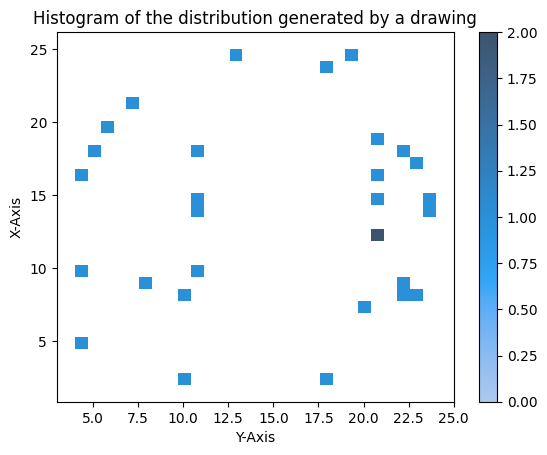

In [31]:
plot_histogram_from_points(x[:30], histplot_kwargs=dict(bins=28))
plt.show()

# Probando clase `GibbsPosteriorPiN` datos modificados

Probamos el algoritmo de Gibbs utilizando los datos modificados.

In [32]:
%%time
mcmc = GibbsPosteriorPiN(data=x[:30], models=faces_modified, seed=rng)

2023-03-20 10:44:38,841: INFO [bwb.distributions:270] init PosteriorPiN: n_data=30, n_models=161666
2023-03-20 10:44:50,281: INFO [bwb.distributions:504] Executing _first_step
2023-03-20 10:44:50,303: INFO [bwb.distributions:511] First model selected: 75375.


CPU times: total: 11.3 s
Wall time: 11.5 s


Muestreamos a partir de de esta instancia.

In [ ]:
%%time
mcmc.rvs(size=100)
mcmc

2023-03-20 10:44:50,377: INFO [bwb.distributions:551] i = 1: last_i = 75375 -> next_i = 93190.
2023-03-20 10:44:50,448: INFO [bwb.distributions:551] i = 3: last_i = 93190 -> next_i = 0.
2023-03-20 10:44:51,726: INFO [bwb.distributions:343] ========== n samples: 1, total time: 1.3905 [seg] ==========
2023-03-20 10:44:51,986: INFO [bwb.distributions:551] i = 76: last_i = 0 -> next_i = 112656.
2023-03-20 10:44:52,011: INFO [bwb.distributions:551] i = 77: last_i = 112656 -> next_i = 0.
2023-03-20 10:44:52,263: INFO [bwb.distributions:551] i = 89: last_i = 0 -> next_i = 112656.
2023-03-20 10:44:52,291: INFO [bwb.distributions:551] i = 90: last_i = 112656 -> next_i = 0.
2023-03-20 10:44:52,988: INFO [bwb.distributions:551] i = 122: last_i = 0 -> next_i = 142502.
2023-03-20 10:44:53,011: INFO [bwb.distributions:551] i = 123: last_i = 142502 -> next_i = 0.
2023-03-20 10:44:53,235: INFO [bwb.distributions:343] ========== n samples: 2, total time: 1.5075 [seg] ==========
2023-03-20 10:44:53,534:

Notamos que el algoritmo tiene especial preferencia para la primera cara. Esto tiene sentido, pues es de donde se obtuvieron los datos. Sin embargo, por esta misma razón, se intentará correr el algoritmo con los otros datos, excluyendo la primera cara.

In [ ]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# `GibbsPosteriorPiN` con los datos modificacos, sin el primer dibujo

In [ ]:
%%time
mcmc = GibbsPosteriorPiN(data=x[:30], models=faces_modified[1:], seed=rng)

Muestreamos a partir de de esta instancia.

In [ ]:
%%time
mcmc.rvs(size=100)
mcmc

In [ ]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

Notamos que ahora los sampleos se encuentran más "equilibrados". Ahora nos interesaremos en un test de "estrés", querremos probar con $n$ alto.

# `GibbsPosteriorPiN` con $n=50$ sin la primera cara

In [ ]:
%%time
mcmc = GibbsPosteriorPiN(data=x[:50], models=faces_modified[1:], seed=rng)

Muestreamos a partir de de esta instancia.

In [ ]:
%%time
mcmc.rvs(size=100)
mcmc

In [ ]:
faces_modified[0]

In [ ]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# `GibbsPosteriorPiN` con $n=100$ sin la primera cara

In [ ]:
%%time
mcmc = GibbsPosteriorPiN(data=x, models=faces_modified[1:], seed=rng)

Muestreamos a partir de de esta instancia.

In [ ]:
%%time
mcmc.rvs(size=100)
mcmc

In [ ]:
faces_modified[0]

In [ ]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# `GibbsPosteriorPiN` con $n=100$ sin la primera cara

In [ ]:
%%time
mcmc = GibbsPosteriorPiN(data=x, models=faces_original, seed=rng)

Muestreamos a partir de de esta instancia.

In [ ]:
%%time
mcmc.rvs(size=100)
mcmc

In [ ]:
faces_modified[0]

In [ ]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))